# Advanced Machine Learning in Healthcare Coursework
## Finetuning BERT on the MTSamples Corpus
Student Candidate Number: KRQV5

## Preprocessing

Adapted from this blog post https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c

### Split files into train, val, test sets

In [5]:
import os
import random

#https://towardsdatascience.com/masked-language-modelling-with-bert-7d49793e5d2c

random.seed(13)
plaintext_directory = os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset", "plaintext_data")
plaintext_fnames = [fname for fname in os.listdir(plaintext_directory) if fname.endswith(".txt")]

random.shuffle(plaintext_fnames)
val_index = int(0.2*len(plaintext_fnames))
test_index = val_index + int(0.2*len(plaintext_fnames))
fnames_val = plaintext_fnames[:val_index]
fnames_test = plaintext_fnames[val_index:test_index]
fnames_train = plaintext_fnames[test_index:]

Sanity check output

In [6]:
print(len(fnames_train), len(fnames_val), len(fnames_test))
print(fnames_train[:5])

297 98 98
['3930_Discharge Summary.txt', '3360_General Medicine.txt', '1570_Radiology.txt', '3513_Gastroenterology.txt', '2838_Neurology.txt']


### Extract annotated sentences

Helper functions

In [64]:
import nltk

def get_occurance_of_word_in_string(word, string, word_start_idx):
    # Recursively find what nth occurance of the word at word_start_idx is
    first_word_idx = string.find(word)
    # Base case
    if(first_word_idx == word_start_idx):
        return 1
    return 1 + get_occurance_of_word_in_string(word, string[first_word_idx+1:], word_start_idx-first_word_idx-1)
    
def get_n_occurance_words_sentence(list_of_sentences, word, n_occurance):
    num_times_word_prev_seen = 0
    for sentence in list_of_sentences:
        # For each sentence count number of times target word appears
        num_word_occurances = sentence.count(word)
        # If target word appears for nth time in sentence find it's position and return sentence and idx
        if num_word_occurances + num_times_word_prev_seen >= n_occurance:
            occurances_to_mask = n_occurance - num_times_word_prev_seen -1
            anno_start_idx_in_sentence = sentence.replace(word, word.upper(), occurances_to_mask).find(word) 
            return sentence, anno_start_idx_in_sentence
        # If not move to next sentence with word count updated
        num_times_word_prev_seen += num_word_occurances

# Helper functions to convert string to int labels and vice versa
def label_to_int(label):
    return 1 if label == "Disease_Syndrome" else 0

def int_to_label(intLabel):
    return "Disease_Syndrome" if intLabel == 1 else "Other"

def extract_text_from_annotations(annotations, plaintext_directory):
    # For each annotated sentence get these features
    extracts = {"text": [], "idxs":[], "labels":[], "anno":[]}
    for _, anno in annotations.iterrows():
        # Get data from df
        anno_filepath = os.path.join(plaintext_directory, anno.file)
        anno_length = anno.end - anno.start
        anno_text_lower = anno.text.lower()
        with open(anno_filepath, 'r', encoding="utf8") as plaintext_file:
            # Preprocess text to lowercase, strip \n and tidy up whitespace
            plaintext = plaintext_file.read().lower()
            word_occurance = get_occurance_of_word_in_string(anno_text_lower, plaintext, anno.start)
            text_preprocessed = plaintext.replace('\n', " ").replace("   ", " ").replace("  ", " ")
            # Split text into sentences
            list_of_sentences = nltk.sent_tokenize(text_preprocessed)
            anno_sentence, start_idx = get_n_occurance_words_sentence(list_of_sentences, anno_text_lower, word_occurance)
            # Check annotation matches the original
            if(anno_text_lower != anno_sentence[start_idx: start_idx+anno_length]):
                print(anno.text.lower(), anno_sentence[start_idx: start_idx+anno_length], anno_sentence)
            # Save annotation to dict
            extracts["text"] += [anno_sentence]
            extracts["idxs"] += [[start_idx, start_idx+anno_length]]
            extracts["labels"] += [anno["class"]]
            extracts["anno"] += [anno_sentence[start_idx: start_idx+anno_length]]
    return extracts

Do work

In [65]:
import pandas as pd

# Get each splits annotations
annotations = pd.read_csv(os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset","amlh_coursework_annotated.csv"))
annotations_train = annotations[annotations.file.isin(fnames_train)]
annotations_val = annotations[annotations.file.isin(fnames_val)]
annotations_test = annotations[annotations.file.isin(fnames_test)]

# Get annotated sentences
inputs_train = extract_text_from_annotations(annotations_train, plaintext_directory)
inputs_val = extract_text_from_annotations(annotations_val, plaintext_directory)
inputs_test = extract_text_from_annotations(annotations_test, plaintext_directory)

Sanity Check

In [9]:
print(inputs_train.keys())
print([len(feature) for feature in inputs_train.values()])
print([len(feature) for feature in inputs_val.values()])
print([len(feature) for feature in inputs_test.values()])
print({key: feature[0] for key, feature in inputs_train.items()})

dict_keys(['text', 'idxs', 'labels', 'anno'])
[9624, 9624, 9624, 9624]
[2933, 2933, 2933, 2933]
[3099, 3099, 3099, 3099]
{'text': 'she was given a lab sheet to have a cbc with diff as well as a cmp to be drawn prior to her appointment with dr. x. she is instructed to follow up with dr. y if her condition changes regarding her colon cancer.', 'idxs': [197, 209], 'labels': 'Disease_Syndrome', 'anno': 'colon cancer'}


### Tokenise text

In [10]:
from transformers import BertTokenizerFast
import torch

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
max_token_length = 256
tokens_train = tokenizer(inputs_train["text"], return_tensors='pt', padding="max_length", truncation = True, max_length=max_token_length, return_offsets_mapping=True)
tokens_val = tokenizer(inputs_val["text"], return_tensors='pt', padding='max_length', truncation = True, max_length=max_token_length, return_offsets_mapping=True)
tokens_test = tokenizer(inputs_test["text"], return_tensors='pt', padding='max_length', truncation = True, max_length=max_token_length, return_offsets_mapping=True)

inputs_train = {**inputs_train, **tokens_train}
inputs_val = {**inputs_val, **tokens_val}
inputs_test = {**inputs_test, **tokens_test}

Sanity check

In [11]:
print([len(feature) for feature in inputs_train.values()])
print([len(feature) for feature in inputs_val.values()])
print([len(feature) for feature in inputs_test.values()])
print({key: feature[0] for key, feature in tokens_train.items()})

[9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624]
[2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933]
[3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099]
{'input_ids': tensor([  101,  2016,  2001,  2445,  1037,  6845,  7123,  2000,  2031,  1037,
        13581,  2007,  4487,  4246,  2004,  2092,  2004,  1037,  4642,  2361,
         2000,  2022,  4567,  3188,  2000,  2014,  6098,  2007,  2852,  1012,
         1060,  1012,  2016,  2003, 10290,  2000,  3582,  2039,  2007,  2852,
         1012,  1061,  2065,  2014,  4650,  3431,  4953,  2014, 16844,  4456,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,   

### Map tokens to orginal char index

Offset mapping is a list of the start and end char idxs for each token. So here we iterate through to find the tokens which match the original char annotation

In [12]:
import numpy as np

def get_tokens_of_interest_idxs(offset_mapping_list, idxs_list, text, annos):
    toi_idxs = []
    for i, (offset_mapping, idxs, text, anno) in enumerate(zip(offset_mapping_list, idxs_list, text, annos)):
        try:
            token_start = np.where(offset_mapping[:, 0]==idxs[0])[0][0]
            token_end = np.where(offset_mapping[:, 1]==idxs[1])[0][0]
            toi_idxs.append([token_start, token_end+1])
        except:
            # Incorrect annoation of cannot as can
            if text[idxs[0]:idxs[1]] == "can":
                toi_idxs.append([token_start, token_start+1])
                idxs[1] += 3
            else:
                print(text)
    return toi_idxs

inputs_train["toi_idxs"] = get_tokens_of_interest_idxs(inputs_train["offset_mapping"], inputs_train["idxs"], inputs_train["text"], inputs_train["anno"])
inputs_val["toi_idxs"] = get_tokens_of_interest_idxs(inputs_val["offset_mapping"], inputs_val["idxs"], inputs_val["text"], inputs_val["anno"])
inputs_test["toi_idxs"] = get_tokens_of_interest_idxs(inputs_test["offset_mapping"], inputs_test["idxs"], inputs_test["text"], inputs_test["anno"])

Sanity check

In [13]:
print(inputs_train.keys())
print([len(feature) for feature in inputs_train.values()])
print([len(feature) for feature in inputs_val.values()])
print([len(feature) for feature in inputs_test.values()])
print(tokenizer.decode(inputs_train["input_ids"][0][inputs_train["toi_idxs"][0][0]:inputs_train["toi_idxs"][0][1]]))
print(inputs_train["anno"][0])

dict_keys(['text', 'idxs', 'labels', 'anno', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'toi_idxs'])
[9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624]
[2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933]
[3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099]
colon cancer
colon cancer


### Create NER Labels

In [14]:
def generate_NER_labels(toi_idxs, labels, max_token_length):
    print(len(toi_idxs), len(labels))
    # By default ignore all tokens
    ner_labels = torch.ones(len(toi_idxs), max_token_length, dtype=torch.long) * -100
    # For tokens of interest change to label index
    for idx, (toi_idx) in enumerate(toi_idxs):
        ner_labels[idx, toi_idx[0]: toi_idx[1]] = label_to_int(labels[idx])
    return ner_labels

In [15]:
inputs_train["ner_labels"] = generate_NER_labels(inputs_train["toi_idxs"], inputs_train["labels"], max_token_length)
inputs_val["ner_labels"] = generate_NER_labels(inputs_val["toi_idxs"], inputs_val["labels"], max_token_length)
inputs_test["ner_labels"] = generate_NER_labels(inputs_test["toi_idxs"], inputs_test["labels"], max_token_length)

9624 9624
2933 2933
3099 3099


In [16]:
print(inputs_train.keys())
print([len(feature) for feature in inputs_train.values()])
print([len(feature) for feature in inputs_val.values()])
print([len(feature) for feature in inputs_test.values()])
print(inputs_train["labels"][0], inputs_train["toi_idxs"][0])
print(inputs_train["ner_labels"][0])

dict_keys(['text', 'idxs', 'labels', 'anno', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'toi_idxs', 'ner_labels'])
[9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624]
[2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933]
[3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099]
Disease_Syndrome [48, 50]
tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
           1,    1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100

### Create masked labels

In [17]:
import copy
def add_masked_labels_to_inputs(inputs):
    inputs['gt_tokens'] = inputs["input_ids"].detach().clone()
    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs["input_ids"].shape)
    # create mask array excluding masking special tokens
    mask_arr = (rand < 0.15) * (inputs["input_ids"]!= 101) * \
            (inputs["input_ids"] != 102) * (inputs["input_ids"] != 0)
    # Extract indicies to be masked
    selection = []
    for i in range(inputs["input_ids"].shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )

    # Mask them
    for i in range(inputs["input_ids"].shape[0]):
        inputs["input_ids"][i, selection[i]] = 103
    return inputs

inputs_train = add_masked_labels_to_inputs(inputs_train)
inputs_val = add_masked_labels_to_inputs(inputs_val)
inputs_test = add_masked_labels_to_inputs(inputs_test)

Sanity check

In [18]:
print(inputs_train.keys())
print([len(feature) for feature in inputs_train.values()])
print([len(feature) for feature in inputs_val.values()])
print([len(feature) for feature in inputs_test.values()])

print(tokenizer.decode(inputs_train["input_ids"][0]))
print(tokenizer.decode(inputs_train["gt_tokens"][0]))

dict_keys(['text', 'idxs', 'labels', 'anno', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'toi_idxs', 'ner_labels', 'gt_tokens'])
[9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624, 9624]
[2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933, 2933]
[3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099, 3099]
[CLS] she was given a lab sheet to have a cbc with diff as well as a cmp to be drawn prior [MASK] [MASK] appointment with dr. [MASK]. she [MASK] [MASK] to follow up with dr. y [MASK] her condition changes regarding her [MASK] cancer. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

### Load into Pytorch Datasets and Dataframes

In [19]:
class MT_NERSamplesDataset(torch.utils.data.Dataset):
    def __init__(self, extracts):
        self.extracts = extracts
    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.extracts.items()}
    def __len__(self):
        return len(self.extracts["input_ids"])
    # Methods to print string rep of a sample
    def get_phrase(sample):
        text = sample["text"]
        idxs = sample["idxs"]
        return text[idxs[0]:idxs[1]]
    def get_decode_tokens(sample, tokenizer):
        input_ids = sample["input_ids"]
        toi_idxs = sample["toi_idxs"]
        return tokenizer.decode(sample["input_ids"])
    def sample_to_string(sample, tokenizer):
        string = "Label: "+ sample["labels"] + ","
        string += " Orginal anno: "+ sample["anno"] + ","
        string += " Indexed anno: "+ MT_NERSamplesDataset.get_phrase(sample) + ","
        string += " Tokenised anno: "+ MT_NERSamplesDataset.get_decode_tokens(sample, tokenizer) + ","
        string += " Text: "+ sample["text"]
        return string

In [20]:
datasets = {"train": MT_NERSamplesDataset(inputs_train), "val": MT_NERSamplesDataset(inputs_val), "test": MT_NERSamplesDataset(inputs_test)}
dataloaders = {key: torch.utils.data.DataLoader(dataset, batch_size=8) for key, dataset in datasets.items()}
dataloaders["train"] = torch.utils.data.DataLoader(datasets["train"], batch_size=8, shuffle=True)

Sanity check output

In [21]:
print([len(dataset) for dataset in datasets.values()])
print([len(dataloader) for dataloader in dataloaders.values()])
sample = datasets["train"][0]
print(sample.keys())
print(MT_NERSamplesDataset.sample_to_string(sample, tokenizer))

[9624, 2933, 3099]
[1203, 367, 388]
dict_keys(['text', 'idxs', 'labels', 'anno', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'toi_idxs', 'ner_labels', 'gt_tokens'])
Label: Disease_Syndrome, Orginal anno: colon cancer, Indexed anno: colon cancer, Tokenised anno: [CLS] she was given a lab sheet to have a cbc with diff as well as a cmp to be drawn prior [MASK] [MASK] appointment with dr. [MASK]. she [MASK] [MASK] to follow up with dr. y [MASK] her condition changes regarding her [MASK] cancer. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

## Unsupervised Training

Training loop

In [22]:
from tqdm import tqdm
import copy

def train_model(model, dataloaders, optim, label_key, device):
    # Init training variables
    num_epochs = 3
    loss_log = {"train":[], "val":[]}
    optim.zero_grad()
    best_model_state_dict = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    num_batches = len(dataloaders["train"]) + len(dataloaders["val"])
    num_steps = num_epochs*(len(dataloaders["train"])+len(dataloaders["val"]))
    
    with tqdm(total=num_steps) as pbar:
        for epoch in range(num_epochs):
            for phase in ["train", "val"]:
                pbar.set_description(f'Epoch {epoch}, Phase {phase}')
                running_loss = 0.0
                model = model.train() if phase == 'train' else model.eval()
                
                for batch in dataloaders[phase]:
                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch[label_key].to(device)
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(input_ids, attention_mask=attention_mask,
                                    labels=labels)
                        loss = outputs.loss
                        if phase == 'train':
                            loss.backward()
                            optim.step()
                            optim.zero_grad()
                    pbar.update(1)
                    running_loss += loss.item()
                # Log losses and update saved model    
                epoch_loss = running_loss / len(dataloaders[phase])
                if phase == 'val' and epoch_loss<best_loss:
                    best_loss = epoch_loss
                    best_model_state_dict = copy.deepcopy(model.state_dict())
                loss_log[phase].append(epoch_loss)
                pbar.set_postfix(loss=epoch_loss)                
    # Reload best model
    model.load_state_dict(best_model_state_dict)
    return model, loss_log

### Hyperparmeter Search
In line with the finetuning method outlined in the original BERT paper

In [26]:
from transformers import AdamW, BertForMaskedLM

hyperparam_losses = {}
device = 'cuda' if torch.cuda.is_available else 'cpu'
for lr in range(2, 6):
    model = BertForMaskedLM.from_pretrained('bert-base-uncased')
    model.to(device)
    # initialize optimizer
    optim = AdamW(model.parameters(), lr=lr*10**-5)
    model, loss_log = train_model(model, dataloaders, optim, "gt_tokens", device)
    hyperparam_losses[lr] = loss_log
    model_file = os.path.join(f"models_lr_{lr}")
    model.save_pretrained(model_file)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch 0, Phase train:   3%|▎         | 154/4710 [00:44<22:04,  3.44it/s]


KeyboardInterrupt: 

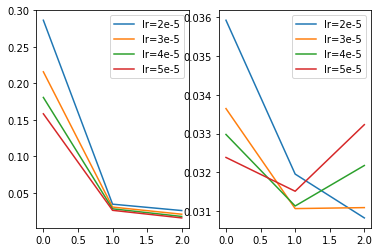

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
for lr, losses in hyperparam_losses.items():
    axs[0].plot(losses["train"], label=f"lr={lr}e-5")
    axs[1].plot(losses["val"], label=f"lr={lr}e-5")

axs[0].legend()
axs[1].legend()

Load best model (found to be lr 2*10-5)

In [29]:
from transformers import BertForMaskedLM
model = BertForMaskedLM.from_pretrained("models_lr_2")

Example output

In [30]:
batch = next(iter(dataloaders["test"]))
model.to(device)
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
gt_tokens = batch["gt_tokens"]
anno = batch["anno"]
with torch.set_grad_enabled(False):
    outputs = model(input_ids, attention_mask=attention_mask)
_, preds = torch.max(outputs.logits, 2)
print(preds.size())
idx = 0
print(tokenizer.decode(preds[idx]))
print(tokenizer.decode(gt_tokens[idx]))
print(tokenizer.decode(input_ids[idx]))

torch.Size([8, 256])
[CLS] reason for consultation : recurrent abscesses in the thigh, as well as the pubic bone for at least about 2 years. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

## Clustering
### Get final hidden layer representations
Helper functions

In [31]:
def get_hidden_layer_reps(model, dataloader, device, max_token_length, layer):
    hidden_layer_reps = torch.zeros(len(dataloader.dataset), max_token_length, model.config.hidden_size)
    idx = 0
    for batch in dataloader:
        input_ids = batch["gt_tokens"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        with torch.set_grad_enabled(False):
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        batch_size = input_ids.size(0)
        hidden_layer_reps[idx:idx+batch_size] = outputs.hidden_states[layer]
        idx += batch_size
    return hidden_layer_reps.cpu()

def get_av_hidden_layer_rep_for_toi_layer(hidden_layer_reps, toi_idxs):
    av_hidden_layer_rep_toi = torch.zeros(hidden_layer_reps.size(0), hidden_layer_reps.size(2))
    for i, (hidden_layer_rep, toi_idx) in enumerate(zip(hidden_layer_reps, toi_idxs)):
        # Extract hidden layer reps of interest
        hidden_layer_rep_oi = hidden_layer_rep[toi_idx[0]:toi_idx[1]]
        # Average them as normally word > 1 token
        av_hidden_layer_rep_toi[i] = hidden_layer_rep_oi.mean(dim=0)
    return av_hidden_layer_rep_toi

Do work

In [32]:
model.to(device)
dataloaders["train"] = torch.utils.data.DataLoader(datasets["train"], batch_size=8, shuffle=False)
model.eval()
hidden_final_layer_train = get_hidden_layer_reps(model, dataloaders["train"], device, max_token_length, -1)
hidden_final_layer_toi_train = get_av_hidden_layer_rep_for_toi_layer(hidden_final_layer_train, inputs_train["toi_idxs"])

hidden_final_layer_test = get_hidden_layer_reps(model, dataloaders["test"], device, max_token_length, -1)
hidden_final_layer_toi_test = get_av_hidden_layer_rep_for_toi_layer(hidden_final_layer_test, inputs_test["toi_idxs"])
model.to("cpu")

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

### Kmeans clustering

In [33]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Scale then cluster
scaler = StandardScaler().fit(hidden_final_layer_toi_train)
scaled_data_train = scaler.transform(hidden_final_layer_toi_train)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=20).fit(scaled_data_train)

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1407
           1       0.94      0.81      0.87      1692

    accuracy                           0.87      3099
   macro avg       0.87      0.87      0.87      3099
weighted avg       0.88      0.87      0.87      3099

[[1324   83]
 [ 324 1368]]


Text(0.5, 15.0, 'SemEHR Label')

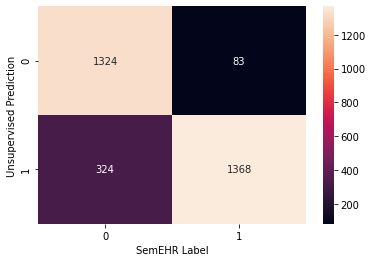

In [34]:
import seaborn as sns
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report

gt = np.array([label_to_int(label) for label in inputs_test["labels"]])

# Make predictions on test set
scaled_data_test = scaler.transform(hidden_final_layer_toi_test)
k_pred_test = kmeans.predict(scaled_data_test)
# Dont know which cluster is which so switch if accuracy less than chance
if accuracy_score(gt, k_pred_test) < 0.5:
    k_pred_test = np.where(k_pred_test==1, 0, 1)

# Get metrics
print(classification_report(gt, k_pred_test))
cm = confusion_matrix(gt, k_pred_test)
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel("Unsupervised Prediction")
plt.xlabel("SemEHR Label")

PCA decomposition of the clusterting. Adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

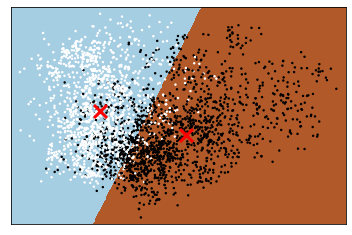

In [35]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2).fit(scaled_data_test)
reduced_data_test = pca.transform(scaled_data_test)
colours = ['k' if label == 1 else "w" for label in gt]

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .1     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data_test[:, 0].min() - 1, reduced_data_test[:, 0].max() + 1
y_min, y_max = reduced_data_test[:, 1].min() - 1, reduced_data_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(pca.inverse_transform(np.c_[(xx.ravel()), yy.ravel()]))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")


# disease_test= np.array([data for data, label in zip(reduced_data_train, labels) if label == "Disease_Syndrome"])

plt.scatter(reduced_data_test[:, 0], reduced_data_test[:, 1], s=2, c = colours)

# Plot the centroids as a white X
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="r", zorder=10)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

Get list of positive SemEHR labels with max distance from diease syndrome centroid

In [ ]:
false_positives = {"anno":[], "distance":[]}
for idx, (label, pred) in enumerate(zip(gt, k_pred_test)):
    if label == 1 and pred == 0:
        false_positives["anno"].append(datasets["test"][idx]["anno"])
        false_positives["distance"].append(k_trans[idx][1])
        
false_positives_df = pd.DataFrame.from_dict(false_positives)
false_positives_df.sort_values('distance', ascending=False).head(10)

,anno,distance
301,cross,40.922421
24,ludwig,39.485924
128,cad,39.475945
91,barlow,39.379154
21,roth,38.801650
20,roth,38.550009
302,cross,38.229595
298,tia,37.670741
242,cortex,37.276733
65,catch,37.090974


## Supervised Training
LR hyperparamter search

In [ ]:
from transformers import AdamW, BertForTokenClassification
hyperparam_losses = {}
for lr in range(2, 6):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = BertForTokenClassification.from_pretrained('bert-base-uncased')
    model.to(device)
    # initialize optimizer
    optim = AdamW(model.parameters(), lr=lr*10**-5)
    model, loss_log = train_model(model, dataloaders, optim, "ner_labels", device)
    hyperparam_losses[lr] = loss_log
    model_file = os.path.join(f"models_supervised_lr_{lr}")
    model.save_pretrained(model_file)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

Plot losses

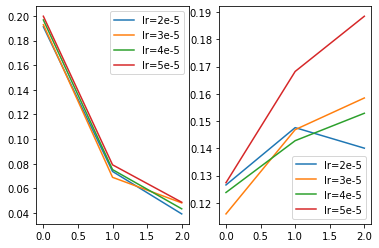

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
for lr, losses in hyperparam_losses.items():
    axs[0].plot(losses["train"], label=f"lr={lr}e-5")
    axs[1].plot(losses["val"], label=f"lr={lr}e-5")

axs[0].legend()
axs[1].legend()

Load best model

In [44]:
from transformers import BertForTokenClassification
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForTokenClassification.from_pretrained("models_supervised_lr_3").to(device)

Make predicitions

In [60]:
torch.set_grad_enabled(False)
# prob_log = torch.zeros(dataloader["test"]) 
pred_log = torch.zeros(len(dataloaders["test"].dataset)) 
prob_log = torch.zeros(len(dataloaders["test"].dataset))
batch_idx = 0
for batch in dataloaders["test"]:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    toi_idxs = batch["toi_idxs"]
    with torch.set_grad_enabled(False):
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.nn.Softmax(2)(outputs.logits)
    for idx, prob in enumerate(probs):
        toi_start = toi_idxs[0][idx]
        toi_end = toi_idxs[1][idx]
        prob_oi = prob[toi_start:toi_end]
        mean_prob_oi = torch.mean(prob_oi, dim=0)
        prob_log[batch_idx+idx] = mean_prob_oi[1].item()
        _, pred_log[batch_idx+idx] = torch.max(mean_prob_oi, dim=0)
    batch_idx += len(input_ids)

Output metrics

1692
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1407
           1       0.95      0.97      0.96      1692

    accuracy                           0.95      3099
   macro avg       0.95      0.95      0.95      3099
weighted avg       0.95      0.95      0.95      3099

[[1315   92]
 [  53 1639]]


Text(0.5, 15.0, 'SemEHR Label')

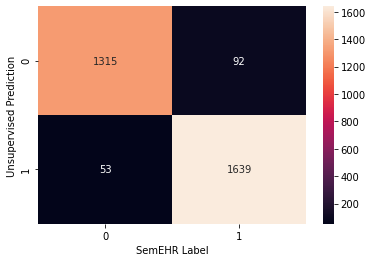

In [61]:
import seaborn as sns
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report
gt = np.array([label_to_int(label) for label in inputs_test["labels"]])
print(sum(gt))
print(classification_report(gt, pred_log))
cm = confusion_matrix(gt, pred_log)
print(cm)
sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel("Unsupervised Prediction")
plt.xlabel("SemEHR Label")

In [62]:
false_positives = {"anno":[], "distance":[]}
for idx, (label, pred) in enumerate(zip(gt, pred_log)):
    if label == 1 and pred == 0:
        false_positives["anno"].append(datasets["test"][idx]["anno"])
        false_positives["distance"].append(1-prob_log[idx])
        
false_positives_df = pd.DataFrame.from_dict(false_positives)
false_positives_df.sort_values('distance', ascending=False).head(10)

,anno,distance
43,cortex,tensor(0.9790)
23,thorax,tensor(0.9763)
45,anal canal,tensor(0.9707)
39,thoracic,tensor(0.9699)
32,anus,tensor(0.9558)
51,cecal polyp,tensor(0.9500)
46,left ear,tensor(0.9274)
35,postop pain,tensor(0.9199)
7,multi,tensor(0.9152)
52,cross,tensor(0.9082)
